In [2]:
import os
import torch
from tqdm import tqdm
# torch.nn contains the building blocks for neural networks.
import torch.nn as nn # for network layers
import torch.optim as optim # for optimization algorithms
import torch.nn.functional as F # for activation funtions
from torch.utils.data import DataLoader, random_split # dataloader for batching
import torchvision.datasets as datasets # to download common datasets
import torchvision.transforms as transforms # for image preprocessing
import matplotlib.pyplot as plt # to plot examples from the dataset
from torch.utils.data.dataset import Dataset
from skimage import io # to read the images
from skimage.color import rgba2rgb # to convert the images to RGB
import numpy as np

from torch.utils.tensorboard import SummaryWriter

# to render the plots in notebooks
%matplotlib inline

# The Oxford-IIIT Pet Dataset
Checkout the [website](https://www.robots.ox.ac.uk/~vgg/data/pets/).

Parkhi OM, Vedaldi A, Zisserman A, Jawahar CV. Cats and dogs. In:
Proceedings of the IEEE Conference on Computer Vision and Pattern
Recognition. Providence: IEEE Computer Society; 2012.

### Download the dataset

In [27]:
import urllib.request
import tarfile

# Define the URL for the dataset
url = 'http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz'

# Define the file path for the downloaded dataset
file_path = 'pets.tar.gz'

# Download the dataset from the URL
urllib.request.urlretrieve(url, file_path)

# Extract the downloaded file
with tarfile.open(file_path, 'r:gz') as tar:
    tar.extractall()
    
# Delete the downloaded .tar.gz file
os.remove(file_path)

print('Oxford-IIIT Pet Dataset downloaded and extracted successfully!')


Oxford-IIIT Pet Dataset downloaded and extracted successfully!


In [33]:
# loading the dataset

import torch
from torchvision import transforms, datasets

# Set the path to the dataset directory
data_directory = "/Users/nahid007/desktop/datasets"

# Define the transformations to be applied to the dataset
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the dataset
dataset = datasets.ImageFolder(root=data_directory, transform=transform)

# Define the data loader
batch_size = 32
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Number of images in dataset:  7376


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


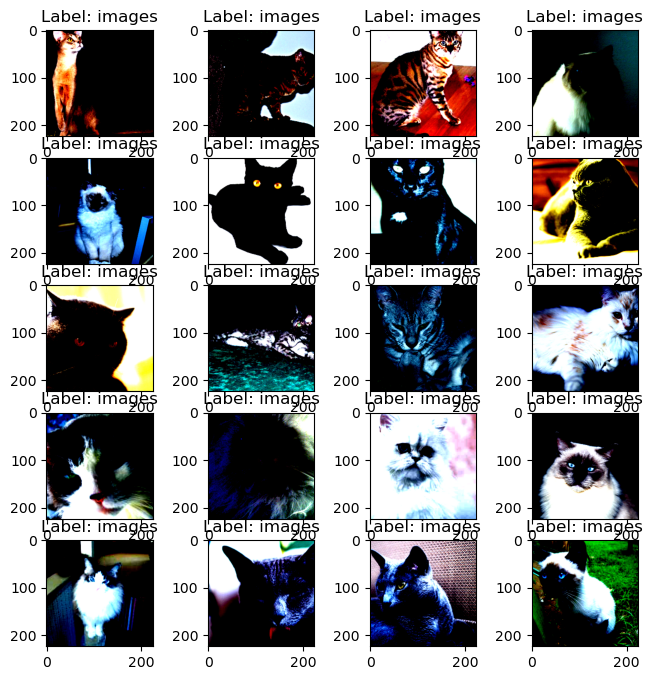

In [34]:
# Print the length of the dataset
print("Number of images in dataset: ", len(dataset))

# Show some sample images
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img_idx = i*100
    img, label = dataset[img_idx]
    fig.add_subplot(rows, columns, i)
    plt.title("Label: "+dataset.classes[label])
    plt.imshow(img.permute(1, 2, 0))
plt.show()


In [35]:
# cleaning data
import torch
import os
from  PIL import Image
from torchvision import transforms

transform = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), 
                                transforms.ToTensor(), 
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

def clean(root_dir = 'images/',transform = transform):
    files =  [f'{root_dir}{file}' for file in os.listdir(root_dir)]
    for file in files:
        try:
            transform(Image.open(file))
        except:
            os.remove(file)

if __name__ == '__main__':
    clean()

In [2]:
# writing a dataset class
from torch.utils.data import Dataset
from  PIL import Image
from torchvision import transforms


class pets(Dataset):
    def __init__(self, root_dir = 'images/', transform = False):
        self.root_dir = root_dir
        self.labels = self.__getlabels__()
        self.transform = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), 
                                             transforms.ToTensor(), 
                                             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])


    def __getlabels__(self):
        files = [file for file in os.listdir(self.root_dir)]
        files = [file.split('.')[0] for file in files]
        files = [file.split('_')[:-1] for file in files]
        files = ['_'.join(file) for file in files]
        labels = list(set(files))
        return dict(zip(labels,torch.arange(len(labels))))

    def __getfiles__(self):
        return [f'{self.root_dir}{file}' for file in os.listdir(self.root_dir)]

    def __len__(self):
        return len(self.__getfiles__())
    
    def __getitem__(self,idx):
        file_name = self.__getfiles__()[idx]
        img = self.transform(Image.open(file_name))
        label =  ('_').join(file_name.split('.')[0].split('/')[-1].split('_')[:-1])
        return img,self.labels[label]


In [3]:
# creating another cnn model

class PetCNN(nn.Module):
    def __init__(self, num_classes=37):
        super(PetCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(28*28*128, 512)
        self.relu4 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        x = x.view(-1, 28*28*128)
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    

### Load the data

In [4]:
# loading and splitting data
dataset = pets() 
train_size = round(int(len(dataset)*.8))
test_size = len(dataset)-train_size
train_set, val_set = torch.utils.data.random_split(dataset, [train_size,test_size])

### Define model hyperparameters

In [16]:
model = PetCNN()
print(model)

# Estimating the number of parameters
num_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {num_params}")

PetCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=512, bias=True)
  (relu4): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=37, bias=True)
)
Number of parameters: 51492965


### Initialize the model

In [5]:
# Set the GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PetCNN().to(device)

### Define training hyperparameters

In [6]:
# training hyperparameters
batch_size = 64
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 20

### Create dataloaders

In [7]:
# creating dataloaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False)


### Train the model

In [8]:
# Define training function
def train(model, dataloader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    
    for inputs, labels in tqdm(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        
        loss.backward()
        optimizer.step()
    
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)
    
    return epoch_loss, epoch_acc

# Define validation function
def validate(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_acc = running_corrects.double() / len(dataloader.dataset)
    
    return epoch_loss, epoch_acc

In [10]:
# Train the model
train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

best_valid_acc = 0.0  # variable to keep track of the best validation accuracy so far

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer)
    valid_loss, valid_acc = validate(model, val_loader, criterion)
    
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.4f}")
          
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_losses': train_losses,
            'train_accs': train_accs,
            'valid_losses': valid_losses,
            'valid_accs': valid_accs
        }
        torch.save(checkpoint, 'pet_checkpoint.pt')

100%|███████████████████████████████████████████| 24/24 [00:41<00:00,  1.74s/it]


Epoch 1/20, Train Loss: 3.7102, Train Acc: 0.0271, Valid Loss: 3.6076, Valid Acc: 0.0318


100%|███████████████████████████████████████████| 24/24 [00:42<00:00,  1.78s/it]


Epoch 2/20, Train Loss: 3.5505, Train Acc: 0.0468, Valid Loss: 3.4562, Valid Acc: 0.0732


100%|███████████████████████████████████████████| 24/24 [00:44<00:00,  1.85s/it]


Epoch 3/20, Train Loss: 3.4328, Train Acc: 0.0715, Valid Loss: 3.3795, Valid Acc: 0.0867


100%|███████████████████████████████████████████| 24/24 [00:43<00:00,  1.82s/it]


Epoch 4/20, Train Loss: 3.3535, Train Acc: 0.0827, Valid Loss: 3.3283, Valid Acc: 0.1084


100%|███████████████████████████████████████████| 24/24 [00:44<00:00,  1.84s/it]


Epoch 5/20, Train Loss: 3.3019, Train Acc: 0.0906, Valid Loss: 3.2945, Valid Acc: 0.0996


100%|███████████████████████████████████████████| 24/24 [00:44<00:00,  1.87s/it]


Epoch 6/20, Train Loss: 3.2418, Train Acc: 0.1066, Valid Loss: 3.2139, Valid Acc: 0.1213


100%|███████████████████████████████████████████| 24/24 [00:45<00:00,  1.88s/it]


Epoch 7/20, Train Loss: 3.0481, Train Acc: 0.1628, Valid Loss: 3.1411, Valid Acc: 0.1450


100%|███████████████████████████████████████████| 24/24 [00:45<00:00,  1.91s/it]


Epoch 8/20, Train Loss: 2.6358, Train Acc: 0.2653, Valid Loss: 3.0871, Valid Acc: 0.1687


100%|███████████████████████████████████████████| 24/24 [00:44<00:00,  1.84s/it]


Epoch 9/20, Train Loss: 2.0601, Train Acc: 0.4183, Valid Loss: 3.3725, Valid Acc: 0.1443


100%|███████████████████████████████████████████| 24/24 [00:44<00:00,  1.85s/it]


Epoch 10/20, Train Loss: 1.4395, Train Acc: 0.5827, Valid Loss: 3.9033, Valid Acc: 0.1355


100%|███████████████████████████████████████████| 24/24 [00:44<00:00,  1.87s/it]


Epoch 11/20, Train Loss: 0.9653, Train Acc: 0.7098, Valid Loss: 4.2930, Valid Acc: 0.1226


100%|███████████████████████████████████████████| 24/24 [00:44<00:00,  1.86s/it]


Epoch 12/20, Train Loss: 0.6821, Train Acc: 0.7957, Valid Loss: 4.5589, Valid Acc: 0.1348


100%|███████████████████████████████████████████| 24/24 [00:44<00:00,  1.85s/it]


Epoch 13/20, Train Loss: 0.5170, Train Acc: 0.8480, Valid Loss: 4.8604, Valid Acc: 0.1328


100%|███████████████████████████████████████████| 24/24 [00:45<00:00,  1.89s/it]


Epoch 14/20, Train Loss: 0.3940, Train Acc: 0.8851, Valid Loss: 5.1061, Valid Acc: 0.1348


100%|███████████████████████████████████████████| 24/24 [00:45<00:00,  1.88s/it]


Epoch 15/20, Train Loss: 0.3218, Train Acc: 0.9038, Valid Loss: 5.9634, Valid Acc: 0.1301


100%|███████████████████████████████████████████| 24/24 [00:45<00:00,  1.89s/it]


Epoch 16/20, Train Loss: 0.2670, Train Acc: 0.9156, Valid Loss: 5.9630, Valid Acc: 0.1362


100%|███████████████████████████████████████████| 24/24 [00:47<00:00,  1.98s/it]


Epoch 17/20, Train Loss: 0.2492, Train Acc: 0.9254, Valid Loss: 5.8379, Valid Acc: 0.1321


100%|███████████████████████████████████████████| 24/24 [00:45<00:00,  1.90s/it]


Epoch 18/20, Train Loss: 0.2020, Train Acc: 0.9410, Valid Loss: 6.2404, Valid Acc: 0.1220


100%|███████████████████████████████████████████| 24/24 [00:45<00:00,  1.88s/it]


Epoch 19/20, Train Loss: 0.1980, Train Acc: 0.9412, Valid Loss: 6.7217, Valid Acc: 0.1179


100%|███████████████████████████████████████████| 24/24 [00:43<00:00,  1.83s/it]

Epoch 20/20, Train Loss: 0.1889, Train Acc: 0.9480, Valid Loss: 6.1350, Valid Acc: 0.1321


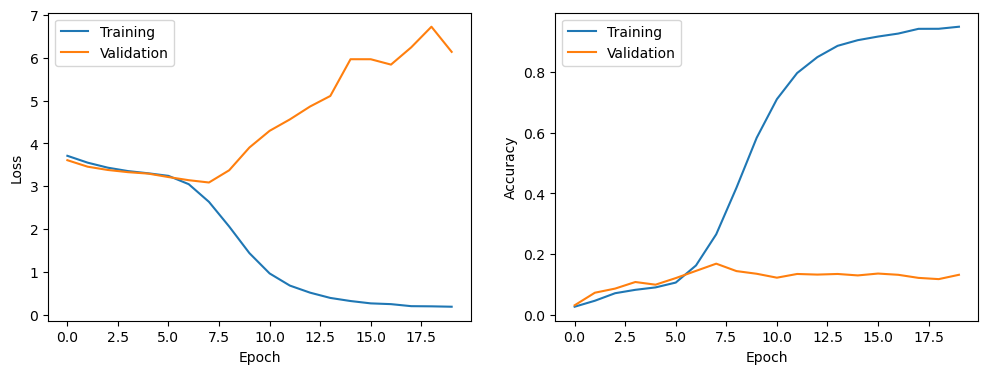

In [11]:
# Plot the training and validation losses and accuracies
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training')
plt.plot(valid_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training')
plt.plot(valid_accs, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()